# Setting Up

In [4]:
# importing libraries
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
import librosa, librosa.display
from IPython.display import Audio
import matplotlib.pyplot as plt
import soundfile as sf
from pydub import AudioSegment
import os
from torch.utils.data import Dataset, DataLoader, TensorDataset

# Importing Data

In [5]:
iemocap_emotion =  pd.read_csv('/kaggle/input/iemocap-emotion-speech-database/iemocap_full_dataset.csv')
iemocap_eng_french = pd.read_csv('/kaggle/input/iemocap-transcriptions-english-french/iemocapTrans.csv')

In [6]:
iemocap_emotion.emotion.unique(), iemocap_emotion.shape

(array(['neu', 'fru', 'xxx', 'sur', 'ang', 'hap', 'sad', 'exc', 'oth',
        'fea', 'dis'], dtype=object),
 (10039, 7))

In [7]:
iemocap_eng_french.emotion.unique(), iemocap_eng_french.shape

(array(['sad', 'fru', 'neu', 'hap', 'exc', 'sur', 'ang', 'fea', 'oth',
        'dis'], dtype=object),
 (10039, 10))

In [8]:
# using iemocap_eng_french dataset
dataset = iemocap_eng_french

In [9]:
dataset.columns

Index(['_id', 'activation', 'dominance', 'emotion', 'end_time', 'start_time',
       'titre', 'to_translate', 'translated', 'valence'],
      dtype='object')

In [10]:
dataset = dataset.drop(['_id', 'valence', 'translated', 'to_translate', 'start_time', 'end_time', 'dominance', 'activation'], axis=1)

In [11]:
dataset.columns

Index(['emotion', 'titre'], dtype='object')

In [12]:
# adding the file path to the dataframe
location = '/kaggle/input/iemocap-transcriptions-english-french/Iemocap_audio/iemocap_audio/IEMOCAP_wav/'

dataset['filepath'] = location + dataset['titre'] + '.wav'

In [13]:
# dataset.drop('titre', axis=1, inplace=True)

In [14]:
iemocap_eng_french_dataset = dataset.copy()

In [15]:
iemocap_eng_french_dataset.head()

,emotion,titre,filepath
0,sad,Ses02M_impro02_F000,/kaggle/input/iemocap-transcriptions-english-f...
1,sad,Ses02M_impro02_M000,/kaggle/input/iemocap-transcriptions-english-f...
2,sad,Ses02M_impro02_F001,/kaggle/input/iemocap-transcriptions-english-f...
3,sad,Ses02M_impro02_F002,/kaggle/input/iemocap-transcriptions-english-f...
4,sad,Ses02M_impro02_M001,/kaggle/input/iemocap-transcriptions-english-f...


In [16]:
iemocap_ravdess_dataset = dataset.copy()

# Data Preprocessing

In [17]:
def show_cat(df):
    print('sad', df.emotion.loc[df.emotion == 'sad'].count())
    print('fru', df.emotion.loc[df.emotion == 'fru'].count())
    print('neu', df.emotion.loc[df.emotion == 'neu'].count())
    print('hap', df.emotion.loc[df.emotion == 'hap'].count())
    print('exc', df.emotion.loc[df.emotion == 'exc'].count())
    print('sur', df.emotion.loc[df.emotion == 'sur'].count())
    print('ang', df.emotion.loc[df.emotion == 'ang'].count())
    print('fea', df.emotion.loc[df.emotion == 'fea'].count())
    print('oth', df.emotion.loc[df.emotion == 'oth'].count())
    print('dis', df.emotion.loc[df.emotion == 'dis'].count())

In [18]:
show_cat(dataset)

sad 1250
fru 2917
neu 1726
hap 656
exc 1976
sur 110
ang 1269
fea 107
oth 26
dis 2


In [19]:
# hecnce adding the datasets from ravdess-emotional-speech-audio dataset 

In [20]:
# loading avdess-emotional-speech-audio dataset

# emotion value dictionary
# 01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised

emotions = {'01': 'neu','02':'oth', '03':'hap', '04':'sad', '05':'ang', '06':'fea', '07':'dis', '08':'sur'}
for dirname, _, filenames in os.walk('/kaggle/input/ravdess-emotional-speech-audio'):
    for filename in filenames:
        file_path = os.path.join(dirname, filename)
        emotion = emotions[filename[6:8]]
        # print(emotion, filename[6:8], filename)
        new_row = pd.DataFrame({'emotion':[emotion],'titre':[filename[:-4]], 'filepath':[file_path]})
        iemocap_ravdess_dataset = pd.concat([iemocap_ravdess_dataset, new_row], ignore_index=True)

In [21]:
iemocap_ravdess_dataset['emotion'].unique()

array(['sad', 'fru', 'neu', 'hap', 'exc', 'sur', 'ang', 'fea', 'oth',
       'dis'], dtype=object)

In [22]:
show_cat(iemocap_ravdess_dataset)

sad 1634
fru 2917
neu 1918
hap 1040
exc 1976
sur 494
ang 1653
fea 491
oth 410
dis 386


In [23]:
iemocap_ravdess_dataset['titre']

0         Ses02M_impro02_F000
1         Ses02M_impro02_M000
2         Ses02M_impro02_F001
3         Ses02M_impro02_F002
4         Ses02M_impro02_M001
                 ...         
12914    03-01-06-01-01-02-07
12915    03-01-05-01-02-02-07
12916    03-01-04-02-01-01-07
12917    03-01-07-02-02-02-07
12918    03-01-05-02-01-02-07
Name: titre, Length: 12919, dtype: object

## Data Preprocessing to have a sequence of fixed lengths

In [24]:
def length_fixing(sample):
    
    # each input is defined to have a 1s (1000ms) length
    segment_length = 3000
    temp_df = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
    audio_file_path = sample['filepath']
    file_name = sample['titre']
    # print(file_name, audio_file_path)
    # loading audio using AudioSegment
    audio = AudioSegment.from_file(audio_file_path, format="wav")
    if len(audio) < 3000:
        return temp_df
    segments = [audio[i:i+segment_length] for i in range(0, len(audio), segment_length)]
    
    temp_df = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
    # padding the last segment to match the fixed length
    last_seg_len = len(segments[-1])
    if last_seg_len > 2000:
        padding = AudioSegment.silent(duration=(segment_length - last_seg_len))
        segments[-1] += padding
    else:
        segments = segments[:-1]
    
    for i,segment in enumerate(segments):
            segment.export("/kaggle/working/"+ file_name +f"segment_{i}.wav", format="wav")
            new_record ={
                'emotion':[sample['emotion']],
                'titre' : [file_name +f"segment_{i}"],
                'filepath' : ["/kaggle/working/"+ file_name +f"segment_{i}.wav"]
            }
            temp_df = pd.concat([temp_df, pd.DataFrame(new_record)], ignore_index=True)    
    return temp_df

In [25]:
# segmenting iemocap_eng_french dataset
iemocap_eng_french_seg = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
    
for _, row in iemocap_eng_french_dataset.iterrows():
    temp_df = length_fixing(row)
    if temp_df.shape[0]:
        iemocap_eng_french_seg = pd.concat([iemocap_eng_french_seg, temp_df], ignore_index=True)    

In [26]:
show_cat(iemocap_eng_french_seg)

sad 1762
fru 3219
neu 1517
hap 669
exc 2207
sur 63
ang 1442
fea 75
oth 27
dis 0


In [27]:
iemocap_eng_french_seg.shape

(10981, 3)

In [28]:
iemocap_eng_french_seg.head()

,emotion,titre,filepath
0,sad,Ses02M_impro02_M000segment_0,/kaggle/working/Ses02M_impro02_M000segment_0.wav
1,sad,Ses02M_impro02_M000segment_1,/kaggle/working/Ses02M_impro02_M000segment_1.wav
2,sad,Ses02M_impro02_M000segment_2,/kaggle/working/Ses02M_impro02_M000segment_2.wav
3,sad,Ses02M_impro02_F001segment_0,/kaggle/working/Ses02M_impro02_F001segment_0.wav
4,sad,Ses02M_impro02_F001segment_1,/kaggle/working/Ses02M_impro02_F001segment_1.wav


In [29]:
iemocap_eng_french_seg = iemocap_eng_french_seg.drop_duplicates()
iemocap_eng_french_seg.shape

(10981, 3)

In [30]:
# segmenting iemocap_ravdess_dataset dataset
iemocap_ravdess_seg = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
    
for _, row in iemocap_ravdess_dataset.iterrows():
    temp_df = length_fixing(row)
    if temp_df.shape[0]:
        iemocap_ravdess_seg = pd.concat([iemocap_ravdess_seg, temp_df], ignore_index=True)    

In [31]:
iemocap_ravdess_seg.shape

(13863, 3)

In [32]:
show_cat(iemocap_ravdess_seg)

sad 2146
fru 3219
neu 1709
hap 1053
exc 2207
sur 445
ang 1828
fea 461
oth 409
dis 386


In [33]:
iemocap_ravdess_seg.head()

,emotion,titre,filepath
0,sad,Ses02M_impro02_M000segment_0,/kaggle/working/Ses02M_impro02_M000segment_0.wav
1,sad,Ses02M_impro02_M000segment_1,/kaggle/working/Ses02M_impro02_M000segment_1.wav
2,sad,Ses02M_impro02_M000segment_2,/kaggle/working/Ses02M_impro02_M000segment_2.wav
3,sad,Ses02M_impro02_F001segment_0,/kaggle/working/Ses02M_impro02_F001segment_0.wav
4,sad,Ses02M_impro02_F001segment_1,/kaggle/working/Ses02M_impro02_F001segment_1.wav


In [34]:
iemocap_ravdess_seg = iemocap_ravdess_seg.drop_duplicates()
iemocap_ravdess_seg.shape

(12422, 3)

In [35]:
show_cat(iemocap_ravdess_seg)

sad 1954
fru 3219
neu 1613
hap 861
exc 2207
sur 254
ang 1635
fea 268
oth 218
dis 193


## Resolving Class Imbalance

In [36]:
# backgound noise preprocessing

noise_dir= '/kaggle/input/bg-noise-dataset'
noise_files = os.listdir(noise_dir)
#print(noise_files)

def crop_noise(file_number, length):
    file_path = os.path.join(noise_dir, noise_files[file_number])
    audio = AudioSegment.from_file(file_path, format="wav", sr= 16000)
    cropped_audio = audio[0:length]
    
    return np.array(cropped_audio.get_array_of_samples())

        


In [37]:
# add augmented data for the fea and sur class
# data augmentation by adding 
#      --gaussian white noise
#      --random background noise
#to the audio clips in the fea and sur classes

def add_white_noice(data, noise_factor):
    noise = np.random.randn(len(data))
    noice_data = data + noise_factor * noise
    noice_data = noice_data.astype(type(data[0]))
    return noice_data

def add_bg_noice(data, noise_factor):
    
    random_noise_file = random.randint(0, 4)
    noise = crop_noise(random_noise_file, len(data))
    noice_data = data + noise_factor * noise
    noice_data = noice_data.astype(type(data[0]))
    return noice_data


In [38]:
import random

In [39]:
def resolve_imbalance_1(dataset):
    
    for _, row in dataset.loc[(dataset.emotion == 'sur') | (dataset.emotion == 'fea')].iterrows():
        signal, sr = librosa.load(row['filepath'])
        # print(row['titre'])
        # method = random.choice([add_bg_noice, add_white_noice])
        # print(method)
        noise_signal = add_white_noice(signal, 0.001)
        sf.write('/kaggle/working/' + row['titre'] + '-noise.wav', noise_signal, sr)
        new_record = {
            'emotion': [row['emotion']],
            'titre': [row['titre'] + '-noise'],
            'filepath': ['/kaggle/working/' + row['titre'] + '-noise.wav']
        }
        dataset = pd.concat([dataset, pd.DataFrame(new_record)], ignore_index=True)
    return dataset

In [40]:
def resolve_imbalance_2(dataset):
    for _, row in dataset.loc[(dataset.emotion == 'dis')].iterrows():
        signal, sr = librosa.load(row['filepath'])
        # print(row['titre'])
        # method = random.choice([add_bg_noice, add_white_noice])
        # print(method)
        noise_signal = add_white_noice(signal, 0.001)
        sf.write('/kaggle/working/' + row['titre'] + '-noise.wav', noise_signal, sr)
        new_record = {
            'emotion': [row['emotion']],
            'titre': [row['titre'] + '-noise'],
            'filepath': ['/kaggle/working/' + row['titre'] + '-noise.wav']
        }
        dataset = pd.concat([dataset, pd.DataFrame(new_record)], ignore_index=True)
    return dataset        

In [41]:
iemocap_eng_french_seg_balanced = resolve_imbalance_1(iemocap_eng_french_seg)
iemocap_eng_french_seg_balanced = resolve_imbalance_2(iemocap_eng_french_seg_balanced)

In [42]:
iemocap_eng_french_seg_balanced.shape

(11119, 3)

In [43]:
show_cat(iemocap_eng_french_seg_balanced)

sad 1762
fru 3219
neu 1517
hap 669
exc 2207
sur 126
ang 1442
fea 150
oth 27
dis 0


In [44]:
iemocap_ravdess_seg_balanced = resolve_imbalance_1(iemocap_ravdess_seg)
iemocap_ravdess_seg_balanced = resolve_imbalance_2(iemocap_ravdess_seg_balanced)

In [45]:
iemocap_ravdess_seg_balanced.shape

(13137, 3)

In [46]:
show_cat(iemocap_ravdess_seg_balanced)

sad 1954
fru 3219
neu 1613
hap 861
exc 2207
sur 508
ang 1635
fea 536
oth 218
dis 386


## Preparing Train and Test datasets

In [47]:
# select iemocap_ravdess_seg_balanced as the final dataset
final_dataset = iemocap_ravdess_seg_balanced.copy()

In [48]:
# remove emotion type = other
final_dataset = final_dataset[~(final_dataset['emotion']=='oth')]

In [49]:
show_cat(final_dataset)

sad 1954
fru 3219
neu 1613
hap 861
exc 2207
sur 508
ang 1635
fea 536
oth 0
dis 386


In [50]:
# train and test data splitting
# let train dataset be a set of 450 samples from each emotion category except disgust
# take 350 samples from disgust

emotions = final_dataset['emotion'].unique()
emotions

array(['sad', 'fru', 'neu', 'exc', 'sur', 'ang', 'hap', 'fea', 'dis'],
      dtype=object)

In [51]:
emotions = np.delete(emotions, -1)
emotions

array(['sad', 'fru', 'neu', 'exc', 'sur', 'ang', 'hap', 'fea'],
      dtype=object)

In [52]:
# train dataset
np.random.seed(42)
train_df = final_dataset[final_dataset['emotion']=='dis'].sample(350)
train_df.shape
#train_df = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])

(350, 3)

In [53]:
for emotion in emotions:
    train_df = pd.concat([train_df, pd.DataFrame(final_dataset[final_dataset['emotion']==emotion].sample(450))], axis =0, ignore_index=True)
train_df.shape

(3950, 3)

In [54]:
show_cat(train_df)

sad 450
fru 450
neu 450
hap 450
exc 450
sur 450
ang 450
fea 450
oth 0
dis 350


In [55]:
# test dataset
test_df = final_dataset.merge(train_df, how='left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
test_df.shape

(8969, 3)

In [56]:
show_cat(test_df)

sad 1504
fru 2769
neu 1163
hap 411
exc 1757
sur 58
ang 1185
fea 86
oth 0
dis 36


In [57]:
# creating validation dataset
# 500 samples from each category
val_df = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
for emotion in test_df['emotion'].unique():
    val_df = pd.concat([val_df, pd.DataFrame(test_df[test_df['emotion']==emotion].sample(35))], axis =0, ignore_index=True)
val_df.shape

(315, 3)

In [58]:
val_df.head()

,emotion,titre,filepath
0,sad,Ses01M_script02_2_F021segment_2,/kaggle/working/Ses01M_script02_2_F021segment_...
1,sad,Ses03F_script01_3_M029segment_1,/kaggle/working/Ses03F_script01_3_M029segment_...
2,sad,Ses05M_impro06_F009segment_0,/kaggle/working/Ses05M_impro06_F009segment_0.wav
3,sad,Ses02F_impro02_F011segment_0,/kaggle/working/Ses02F_impro02_F011segment_0.wav
4,sad,Ses01F_impro02_M013segment_0,/kaggle/working/Ses01F_impro02_M013segment_0.wav


In [59]:
show_cat(val_df)

sad 35
fru 35
neu 35
hap 35
exc 35
sur 35
ang 35
fea 35
oth 0
dis 35


In [60]:
# saving train, test validation datasets to csv files
train_df.to_csv('/kaggle/working/train_dataset.csv', index=False)
test_df.to_csv('/kaggle/working/test_dataset.csv', index=False)
val_df.to_csv('/kaggle/working/validation_dataset.csv', index=False)

In [61]:
# train : val = 0.93 : 0.07

## Using Mel Spectrogram

In [144]:
train_df['emotion'].unique()

array(['dis', 'sad', 'fru', 'neu', 'exc', 'sur', 'ang', 'hap', 'fea'],
      dtype=object)

fru


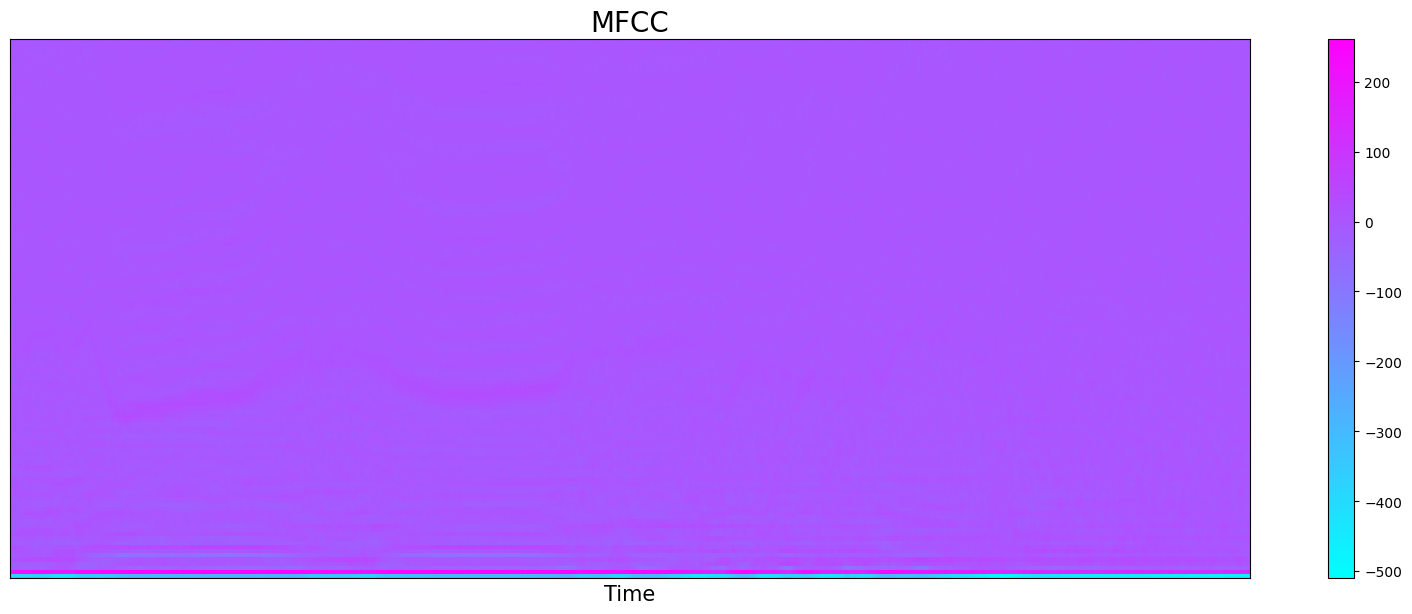

In [151]:
hop_length = 128 #the default spacing between frames
n_fft = 1024 #number of samples 
#cut the sample to the relevant times
i= 1005
y, sr = librosa.load(train_df['filepath'].iloc[i], sr=44000)
print(train_df['emotion'].iloc[i])
MFCCs = librosa.feature.mfcc(y=y,sr=sr, n_fft=n_fft,hop_length=hop_length,n_mfcc=256)
fig, ax = plt.subplots(figsize=(20,7))
librosa.display.specshow(MFCCs,sr=sr, cmap='cool',hop_length=hop_length)
ax.set_xlabel('Time', fontsize=15)
ax.set_title('MFCC', size=20)
plt.colorbar()
plt.show()

In [152]:
MFCCs

array([[-3.97815308e+02, -3.86721191e+02, -3.83920776e+02, ...,
        -4.56798706e+02, -4.56031433e+02, -4.69656281e+02],
       [ 1.98947632e+02,  2.04324982e+02,  2.06066437e+02, ...,
         1.26687408e+02,  1.25490036e+02,  1.15309128e+02],
       [-8.99619675e+00, -1.27789211e+01, -1.54680290e+01, ...,
        -3.13284855e+01, -2.99845676e+01, -2.83561974e+01],
       ...,
       [ 6.16922379e-01, -1.37990284e+00, -4.40647888e+00, ...,
        -2.38834620e-01,  1.82172298e-01, -3.44887733e-01],
       [ 2.03940868e-01, -1.98965836e+00, -3.58728266e+00, ...,
        -1.59991264e+00, -1.53664017e+00, -1.22902203e+00],
       [ 9.70031738e-01,  1.46072388e-01, -1.10176086e-01, ...,
        -5.70213318e-01, -8.28609467e-01, -1.11543655e+00]], dtype=float32)

In [163]:
def extract_features(dataset):
    
    temp_feature_list = []
    temp_label_list = []
    
    # loop through th erows of dataframe
    
    for _, row in dataset.iterrows():
        
        file_path = row['filepath']
        label = row['emotion']
        #print('filepath:', file_path)
        #print('label:', label)
        # loading the audion file
        audio, sr = librosa.load(file_path, sr=44000)
        MFCCs_ = librosa.feature.mfcc(y=audio,sr=sr, n_fft=1024,hop_length=128,n_mfcc=256)
        #print(MFCCs_)
        temp_feature_list.append(MFCCs_)
        temp_label_list.append(label)
        
    return np.array(temp_feature_list), np.array(temp_label_list)

In [164]:
X_train, Y_train = extract_features(train_df)

In [166]:
X_train.shape

(3950, 128, 1032)

In [169]:
X_train[-10]

array([[-8.02618164e+02, -8.04668335e+02, -8.08894409e+02, ...,
        -5.96412170e+02, -5.37139465e+02, -5.15351807e+02],
       [ 2.23466263e+01,  1.96043243e+01,  1.38232555e+01, ...,
         1.28404266e+02,  1.25967590e+02,  1.24715042e+02],
       [ 2.11160641e+01,  1.88191795e+01,  1.36023655e+01, ...,
         1.85750103e+01,  2.07669640e+01,  2.08841972e+01],
       ...,
       [-1.25926018e-01, -4.75473404e-02, -9.14916992e-02, ...,
         7.27740288e-01,  4.97574806e-01,  3.38444710e-01],
       [-1.14618301e-01, -4.53166962e-02, -5.62214851e-02, ...,
         8.19574356e-01,  7.27884293e-01,  4.66542244e-01],
       [-6.74695969e-02, -2.72378922e-02, -2.66261101e-02, ...,
         4.04891968e-01,  2.86258698e-01,  1.20594025e-01]], dtype=float32)

In [170]:
Y_train.shape

(3950,)

In [171]:
X_val, Y_val = extract_features(val_df)

In [172]:
X_val.shape

(315, 128, 1032)

## Ceating Data Loaders

In [173]:
# converting the target class into one-hot-encoded vectors
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()

Y_train_lb = lb.fit_transform(Y_train)
Y_val_lb = lb.fit_transform(Y_val)

In [174]:
# sad  = [0, 0, 0, 0, 0, 0, 0, 1, 0]
# fru = [0, 0, 0, 0, 1, 0, 0, 0, 0]
# neu = [0, 0, 0, 0, 0, 0, 1, 0, 0]
# exc = [0, 0, 1, 0, 0, 0, 0, 0, 0]
# ang = [1, 0, 0, 0, 0, 0, 0, 0, 0]
# hap = [0, 0, 0, 0, 0, 1, 0, 0, 0]
# fea = [0, 0, 0, 1, 0, 0, 0, 0, 0]
# sur = [0, 0, 0, 0, 0, 0, 0, 0, 1]
# dis = [0, 1, 0, 0, 0, 0, 0, 0, 0]

In [175]:
Y_val_lb

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]])

In [176]:
Y_train_lb.shape

(3950, 9)

In [177]:
Y_val_lb.shape

(315, 9)

In [178]:
# saving preprocessed data into csv files
# np.savetxt('/kaggle/working/X_train.csv',X_train, delimiter=',')
# np.savetxt('/kaggle/working/Y_train.csv',X_train, delimiter=',')
# np.savetxt('/kaggle/working/X_val.csv',X_train, delimiter=',')
# np.savetxt('/kaggle/working/Y_val.csv',X_train, delimiter=',')

In [179]:
X_train = torch.tensor(X_train, dtype=torch.float32)
Y_train = torch.tensor(Y_train_lb, dtype=torch.float32)
X_test = torch.tensor(X_val, dtype=torch.float32)
Y_test = torch.tensor(Y_val_lb, dtype=torch.float32)

In [180]:
X_train.shape

torch.Size([3950, 128, 1032])

In [181]:
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size=64)

# Model Building

In [182]:
# building transformers sequence model to predict the emotions
# LSTM NN

## Model_1

In [325]:
import torch
import torch.nn as nn

# Define the model class
class CustomLSTMModel(nn.Module):
    def __init__(self):
        super(CustomLSTMModel, self).__init__()
        
        # Define the layers
        self.lstm = nn.LSTM(input_size= 1032, hidden_size= 512, num_layers=1, batch_first=True)
        self.bn1 = nn.BatchNorm1d(128)
        self.dropout1 = nn.Dropout(0.2)
        self.fc1 = nn.Linear(512, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 6)
    
    def forward(self, x):
        # Define the forward pass
        out, _ = self.lstm(x)
        out = self.bn1(out)
        out = self.dropout1(out)
        out = self.fc1(out)
        out = self.bn2(out)
        out = self.dropout2(out)
        out = self.fc2(out)
        return out



In [326]:
# Create an instance of the model
model = CustomLSTMModel()

# Print the model summary
print(model)


CustomLSTMModel(
  (lstm): LSTM(1032, 512, batch_first=True)
  (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dropout2): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


In [300]:
def train(model, iterator, optimizer, criterion):
    model.train()
    for batch in iterator:
        src, trg = batch  # You'll need to adjust this based on your data
        optimizer.zero_grad()
        output = model(src)
        output = torch.mean(output, axis = 1)
        loss = criterion(output, trg)
        loss.backward()
        optimizer.step()


In [301]:
def evaluate(model, iterator, criterion):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in iterator:
            src, trg = batch  # You'll need to adjust this based on your data
            output = model(src)
            output = torch.mean(output, axis = 1)
            loss = criterion(output, trg)
            total_loss += loss.item()
    return total_loss / len(iterator)


In [302]:
from sklearn.metrics import accuracy_score, confusion_matrix
def calculate_accuracy(model, data_loader):
  model.eval()
  correct = 0
  total = 0

  with torch.no_grad():
      predicted_labels = []
      true_labels = []
      for data in data_loader:
          inputs, labels = data
          output = model(inputs)
          #print(output.shape)
          output = torch.mean(output, axis = 1)
          #print(output)
          max_index = (torch.argmax(output,dim =1).view(-1)).numpy()
          #print("max: ",len(max_index))
          true_label = (torch.argmax(labels,dim =1).view(-1)).numpy()
          #print("true:" ,len(true_label))
          predicted_labels.extend(max_index)
          true_labels.extend(true_label)
  #print(predicted_labels[:-30])
  #print(len(true_labels))
  accuracy = accuracy_score(true_labels, predicted_labels)
  print('Confusion_matrix: ',confusion_matrix(true_labels, predicted_labels))
  return accuracy

# Model Training

## Model_1

In [225]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train your model
N_EPOCHS = 15
for epoch in range(N_EPOCHS):
    train(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

Epoch: 01
	Validation Loss: 2.204
Epoch: 02
	Validation Loss: 2.182
Epoch: 03
	Validation Loss: 2.156
Epoch: 04
	Validation Loss: 2.125
Epoch: 05
	Validation Loss: 2.090
Epoch: 06
	Validation Loss: 2.062
Epoch: 07
	Validation Loss: 2.031
Epoch: 08
	Validation Loss: 2.006
Epoch: 09
	Validation Loss: 1.982
Epoch: 10
	Validation Loss: 1.963
Epoch: 11
	Validation Loss: 1.944
Epoch: 12
	Validation Loss: 1.926
Epoch: 13
	Validation Loss: 1.917
Epoch: 14
	Validation Loss: 1.924
Epoch: 15
	Validation Loss: 1.911


In [ ]:
torch.save(model.state_dict(), 'model_1.pth')

In [231]:
# Calculate accuracy on the validation set
train_accuracy = calculate_accuracy(model, train_loader)

val_accuracy = calculate_accuracy(model, val_loader)

Confusion_matrix:  [[  0  13 201   0  74   0  33 110  19]
 [  0  28   3   2   0   0   0   1 316]
 [  0   0 186   0 125   0  46  93   0]
 [  0  10   9  27   6   0   0  36 362]
 [  0   1  88   0 202   0  38 120   1]
 [  0  16  72   2  85   0  15 207  53]
 [  0   4  95   1 154   0  62 129   5]
 [  0   2  21   1  84   0   7 329   6]
 [  0   4   7   6   0   0   0  14 419]]
Confusion_matrix:  [[ 0  1  9  0  5  0  3 12  5]
 [ 0  4  2  0  0  0  0  1 28]
 [ 0  1 11  0  9  0  1 11  2]
 [ 0  2  0  0  3  0  0  7 23]
 [ 0  1 10  0 10  0  1 12  1]
 [ 0  2  4  0  7  0  2 14  6]
 [ 0  0 10  0  7  0  4  9  5]
 [ 0  2  6  0  6  0  0 15  6]
 [ 0  0  0  0  0  0  0  7 28]]


In [232]:
train_accuracy, val_accuracy

(0.31721518987341774, 0.22857142857142856)

## Model built in tensorflow

In [248]:
# building the model using tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense

In [253]:
input_shape=(128,1032)
model = keras.Sequential()
model.add(LSTM(128,input_shape=input_shape))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(48, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='softmax'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               594432    
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_20 (Dense)            (None, 128)               16512     
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dropout_16 (Dropout)        (None, 64)                0         
                                                                 
 dense_22 (Dense)            (None, 48)                3120      
                                                                 
 dropout_17 (Dropout)        (None, 48)               

In [254]:
adam_optimizer = tf.keras.optimizers.Adam(0.0001)


In [255]:
model.compile(optimizer=adam_optimizer,loss='CategoricalCrossentropy',metrics=['acc'])

In [204]:
X_train_tf = tf.convert_to_tensor(X_train.numpy())
Y_train_tf = tf.convert_to_tensor(Y_train.numpy())
X_val_tf = tf.convert_to_tensor(X_test.numpy())
Y_val_tf = tf.convert_to_tensor(Y_test.numpy())

In [205]:
history = model.fit(X_train_tf, Y_train_tf, epochs=50, batch_size=64, 
                    validation_data=(X_val_tf, Y_val_tf), shuffle=True)

Epoch 1/50
62/62 [==============================] - 27s 358ms/step - loss: 2.2419 - acc: 0.1152 - val_loss: 2.2054 - val_acc: 0.1079
Epoch 2/50
62/62 [==============================] - 22s 360ms/step - loss: 2.2101 - acc: 0.1258 - val_loss: 2.2015 - val_acc: 0.1016
Epoch 3/50
62/62 [==============================] - 22s 361ms/step - loss: 2.1909 - acc: 0.1367 - val_loss: 2.1995 - val_acc: 0.1016
Epoch 4/50
62/62 [==============================] - 22s 354ms/step - loss: 2.1717 - acc: 0.1504 - val_loss: 2.1992 - val_acc: 0.1016
Epoch 5/50
62/62 [==============================] - 22s 355ms/step - loss: 2.1601 - acc: 0.1582 - val_loss: 2.1987 - val_acc: 0.0825
Epoch 6/50
62/62 [==============================] - 22s 359ms/step - loss: 2.1426 - acc: 0.1749 - val_loss: 2.1985 - val_acc: 0.0825
Epoch 7/50
62/62 [==============================] - 22s 360ms/step - loss: 2.1277 - acc: 0.1828 - val_loss: 2.1988 - val_acc: 0.0825
Epoch 8/50
62/62 [==============================] - 22s 354ms/step - 

In [ ]:
# using a different dataset

In [233]:
show_cat(iemocap_ravdess_seg)

sad 1954
fru 3219
neu 1613
hap 861
exc 2207
sur 254
ang 1635
fea 268
oth 218
dis 193


In [234]:
emotions = iemocap_ravdess_seg['emotion'].unique()

In [235]:
emotions

array(['sad', 'fru', 'neu', 'exc', 'sur', 'ang', 'hap', 'oth', 'fea',
       'dis'], dtype=object)

In [236]:
emotions = ['sad', 'fru', 'neu', 'exc', 'sur', 'ang', 'hap', 'fea']

In [237]:
# train val sets
train_df_iemocap = pd.DataFrame(columns=['emotion','titre','filepath'])
for emotion in emotions:
    train_df_iemocap = pd.concat([train_df_iemocap, pd.DataFrame(iemocap_ravdess_seg[iemocap_ravdess_seg['emotion']==emotion].sample(200))], axis =0, ignore_index=True)
train_df_iemocap.shape

(1600, 3)

In [238]:
train_df_iemocap

,emotion,titre,filepath
0,sad,Ses03F_script01_2_F011segment_1,/kaggle/working/Ses03F_script01_2_F011segment_...
1,sad,Ses01M_script01_3_M038segment_3,/kaggle/working/Ses01M_script01_3_M038segment_...
2,sad,Ses02M_impro06_M017segment_0,/kaggle/working/Ses02M_impro06_M017segment_0.wav
3,sad,Ses05M_script01_1_F001segment_1,/kaggle/working/Ses05M_script01_1_F001segment_...
4,sad,Ses04M_impro06_F009segment_2,/kaggle/working/Ses04M_impro06_F009segment_2.wav
...,...,...,...
1595,fea,03-01-06-02-02-02-15segment_0,/kaggle/working/03-01-06-02-02-02-15segment_0.wav
1596,fea,03-01-06-01-02-01-05segment_0,/kaggle/working/03-01-06-01-02-01-05segment_0.wav
1597,fea,03-01-06-01-02-02-21segment_0,/kaggle/working/03-01-06-01-02-02-21segment_0.wav
1598,fea,03-01-06-01-02-02-20segment_0,/kaggle/working/03-01-06-01-02-02-20segment_0.wav


In [239]:
# test dataset
test_df_iemocap = iemocap_ravdess_seg.merge(train_df_iemocap, how='left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
test_df_iemocap.shape

(10822, 3)

In [240]:
val_df_iemocap = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
for emotion in emotions:
    val_df_iemocap = pd.concat([val_df_iemocap, pd.DataFrame(test_df_iemocap[test_df_iemocap['emotion']==emotion].sample(50))], axis =0, ignore_index=True)
val_df_iemocap.shape

(400, 3)

In [241]:
X_train_iemocap, Y_train_iemocap = extract_features(train_df_iemocap)

In [242]:
X_val_iemocap, Y_val_iemocap = extract_features(val_df_iemocap)

In [243]:
X_val_iemocap.shape

(400, 128, 1032)

In [244]:
Y_train_iemocap = lb.fit_transform(Y_train_iemocap)
Y_val_iemocap = lb.fit_transform(Y_val_iemocap)

In [270]:
Y_val_iemocap

array([[0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 1, 0],
       ...,
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 0, 1, ..., 0, 0, 0]])

In [245]:
X_train_tf_ie = tf.convert_to_tensor(X_train_iemocap)
Y_train_tf_ie = tf.convert_to_tensor(Y_train_iemocap)
X_val_tf_ie = tf.convert_to_tensor(X_val_iemocap)
Y_val_tf_ie = tf.convert_to_tensor(Y_val_iemocap)

In [246]:
X_train_tf_ie.shape, Y_train_tf_ie.shape, X_val_tf_ie.shape, Y_val_tf_ie.shape

(TensorShape([1600, 128, 1032]),
 TensorShape([1600, 8]),
 TensorShape([400, 128, 1032]),
 TensorShape([400, 8]))

In [256]:
history = model.fit(X_train_tf_ie, Y_train_tf_ie, epochs=50, batch_size=64, 
                    validation_data=(X_val_tf_ie, Y_val_tf_ie), shuffle=True)

Epoch 1/50
25/25 [==============================] - 13s 410ms/step - loss: 2.1530 - acc: 0.1231 - val_loss: 2.0938 - val_acc: 0.1125
Epoch 2/50
25/25 [==============================] - 9s 361ms/step - loss: 2.1007 - acc: 0.1425 - val_loss: 2.0897 - val_acc: 0.1175
Epoch 3/50
25/25 [==============================] - 9s 369ms/step - loss: 2.0797 - acc: 0.1431 - val_loss: 2.0876 - val_acc: 0.1275
Epoch 4/50
25/25 [==============================] - 9s 371ms/step - loss: 2.0652 - acc: 0.1544 - val_loss: 2.0863 - val_acc: 0.1125
Epoch 5/50
25/25 [==============================] - 10s 388ms/step - loss: 2.0498 - acc: 0.1775 - val_loss: 2.0847 - val_acc: 0.1000
Epoch 6/50
25/25 [==============================] - 9s 366ms/step - loss: 2.0407 - acc: 0.1869 - val_loss: 2.0839 - val_acc: 0.1000
Epoch 7/50
25/25 [==============================] - 9s 373ms/step - loss: 2.0247 - acc: 0.1963 - val_loss: 2.0830 - val_acc: 0.1225
Epoch 8/50
25/25 [==============================] - 10s 397ms/step - loss:

In [ ]:
# Calculate accuracy on the validation set
train_accuracy = calculate_accuracy(model, train_loader_iemocap)

val_accuracy = calculate_accuracy(model, val_loader_iemocap)

## Using only iemocap dataset

In [282]:
dataset_1 = iemocap_eng_french_seg

In [283]:
dataset_1.shape

(10981, 3)

In [284]:
show_cat(dataset_1)

sad 1762
fru 3219
neu 1517
hap 669
exc 2207
sur 63
ang 1442
fea 75
oth 27
dis 0


In [286]:
emotions_1 = ['sad','fru', 'neu','hap','exc','ang']

In [288]:
train_df_1 = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
for emotion in emotions_1:
    train_df_1 = pd.concat([train_df_1, pd.DataFrame(dataset_1[dataset_1['emotion']==emotion].sample(500))], axis =0, ignore_index=True)
train_df_1.shape

(3000, 3)

In [290]:
# test dataset
test_df_1 = dataset_1.merge(train_df_1, how='left', indicator=True).query('_merge == "left_only"').drop(columns=['_merge'])
test_df_1.shape

(7981, 3)

In [291]:
val_df_1 = pd.DataFrame(columns= ['emotion', 'titre', 'filepath'])
for emotion in emotions_1:
    val_df_1 = pd.concat([val_df_1, pd.DataFrame(test_df_1[test_df_1['emotion']==emotion].sample(150))], axis =0, ignore_index=True)
val_df_1.shape

(900, 3)

In [292]:
X_train_1, Y_train_1 = extract_features(train_df_1)

In [293]:
X_val_1, Y_val_1 = extract_features(val_df_1)

In [295]:
Y_train_1b = lb.fit_transform(Y_train_1)
Y_val_1b = lb.fit_transform(Y_val_1)

In [296]:
X_train = torch.tensor(X_train_1, dtype=torch.float32)
Y_train = torch.tensor(Y_train_1b, dtype=torch.float32)
X_test = torch.tensor(X_val_1, dtype=torch.float32)
Y_test = torch.tensor(Y_val_1b, dtype=torch.float32)

In [297]:
train_loader_1 = DataLoader(TensorDataset(X_train, Y_train), batch_size=64, shuffle=True)
val_loader_1 = DataLoader(TensorDataset(X_test, Y_test), batch_size=64)

In [304]:
Y_test

tensor([[0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 0., 1.],
        ...,
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.]])

In [327]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Train your model
N_EPOCHS = 5
for epoch in range(N_EPOCHS):
    train(model, train_loader_1, optimizer, criterion)
    val_loss = evaluate(model, val_loader_1, criterion)
    print(f'Epoch: {epoch+1:02}')
    #print(f'\tTrain Loss: {train_loss:.3f}')
    print(f'\tValidation Loss: {val_loss:.3f}')

Epoch: 01
	Validation Loss: 1.739
Epoch: 02
	Validation Loss: 1.700
Epoch: 03
	Validation Loss: 1.674
Epoch: 04
	Validation Loss: 1.665
Epoch: 05
	Validation Loss: 1.663


In [328]:
# Calculate accuracy on the validation set
train_accuracy = calculate_accuracy(model, train_loader)

val_accuracy = calculate_accuracy(model, val_loader)

Confusion_matrix:  [[160   7  17   4   1  11   0   0]
 [ 62  49  47  10  10  22   0   0]
 [137   1  35   3   2  22   0   0]
 [ 67  14  77   9   7  26   0   0]
 [ 71   9   7  83   4  26   0   0]
 [ 52  12  35  10  68  23   0   0]
 [ 27   7  26   8   6 126   0   0]
 [162   1  20   3   2  12   0   0]]
Confusion_matrix:  [[43  1  3  0  0  3  0  0]
 [21  8 12  1  1  7  0  0]
 [35  0  9  0  0  6  0  0]
 [21  1 20  2  0  6  0  0]
 [19  2  5 16  0  8  0  0]
 [14  2  8  4 12 10  0  0]
 [ 6  2  5  0  1 36  0  0]
 [42  1  5  1  0  1  0  0]]


In [329]:
train_accuracy, val_accuracy

(0.175, 0.18)

# Conclusion

##  * Raw IEMOCAP dataset performes best --> Selected as the final dataset
##  * Need to increase the feature size in the output of Mel Spectrogram to capture more info
##  * Need to increase the Model Complexity
##  * Further improvements ---> Emotion_model_Transformers_2


# Other

REFERENCES:
* https://towardsdatascience.com/audio-deep-learning-made-simple-sound-classification-step-by-step-cebc936bbe5
* https://towardsdatascience.com/recurrent-neural-nets-for-audio-classification-81cb62327990

In [ ]:
from IPython.display import FileLink

In [ ]:
FileLink(r'train_dataset.csv')